### Load LIBRARY

In [ ]:
from google.colab import drive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import shutil
from google.colab.patches import cv2_imshow


import random
import cv2
import scipy.io
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import ndimage, misc
from sklearn.metrics import average_precision_score
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from PIL import Image

import torch.nn as nn
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch.optim import Adam
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR
! pip install torchsummary -q

from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# !pip install kornia -q
# import kornia

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def display(img):
    print(img.shape)
    cv2_imshow(img)


def image_dimension(img):
    if img.shape[0]>512 and img.shape[1]>512:
        img = cv2.resize(img, (1024,1024), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, (672,512), interpolation=cv2.INTER_AREA)

    return img

### Data Load

In [ ]:
drive.mount('/content/myDrive', force_remount=True)

Mounted at /content/myDrive


In [ ]:
shutil.copy("/content/myDrive/MyDrive/edge_unet/BSDS500.zip", "/content")

'/content/BSDS500.zip'

In [ ]:
drive.flush_and_unmount()

In [ ]:
!unzip "/content/BSDS500.zip"

Archive:  /content/BSDS500.zip
  inflating: ground_truth/test/100007.mat  
  inflating: ground_truth/test/100039.mat  
  inflating: ground_truth/test/100099.mat  
  inflating: ground_truth/test/10081.mat  
  inflating: ground_truth/test/101027.mat  
  inflating: ground_truth/test/101084.mat  
  inflating: ground_truth/test/102062.mat  
  inflating: ground_truth/test/103006.mat  
  inflating: ground_truth/test/103029.mat  
  inflating: ground_truth/test/103078.mat  
  inflating: ground_truth/test/104010.mat  
  inflating: ground_truth/test/104055.mat  
  inflating: ground_truth/test/105027.mat  
  inflating: ground_truth/test/106005.mat  
  inflating: ground_truth/test/106047.mat  
  inflating: ground_truth/test/107014.mat  
  inflating: ground_truth/test/107045.mat  
  inflating: ground_truth/test/107072.mat  
  inflating: ground_truth/test/108004.mat  
  inflating: ground_truth/test/108036.mat  
  inflating: ground_truth/test/108069.mat  
  inflating: ground_truth/test/109055.mat  
  

In [ ]:
def load_images(folder):
  images = []
  files = os.listdir(folder)
  files =[i for i in files if '.jpg' in i]
  files.sort()
  print(len(files))
  for file in files:
    img = cv2.imread(os.path.join(folder,file))
    # img = image_dimension(img)
    if img.shape == (481, 321,3):
        img = np.transpose(img,(1,0,2))

    img = image_dimension(img)
    if img is not None:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      images.append(img)
  return images

def load_labels(folder):
    labels = []
    files = os.listdir(folder)
    files.sort()
    print(len(files))
    for filename in files:
        data = (scipy.io.loadmat(os.path.join(folder,filename)))
        segment = ((data['groundTruth'][0][0][0][0][0])*255)
        edge = ((data['groundTruth'][0][0][0][0][1])*255)
        if edge.shape == (481, 321):
            edge = edge.T
        edge = image_dimension(edge)
        labels.append(edge)




    return labels



In [ ]:
xfolder = '/content/images/'
yfolder = '/content/ground_truth/'


xtrain = load_images(xfolder + 'train')
xtest = load_images(xfolder + 'test')
xval = load_images(xfolder + 'val')

# Load Ground Truths Using Majority Vote Notion
ytrain = load_labels(yfolder + 'train')
ytest = load_labels(yfolder + 'test')
yval = load_labels(yfolder + 'val')
# print(len(y_train))

200
200
100
200
200
100


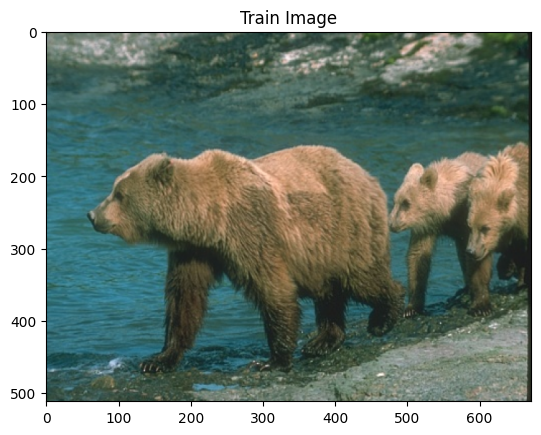

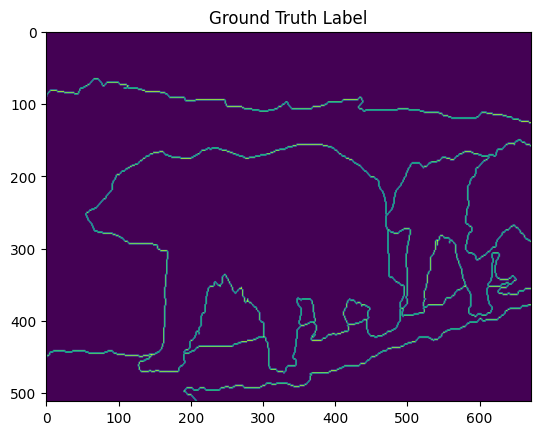

(512, 672)


In [ ]:
plt.imshow(xtrain[0])
plt.title('Train Image')
plt.show()

plt.imshow(ytrain[0])
plt.title('Ground Truth Label')
plt.show()
print(ytrain[0].shape)

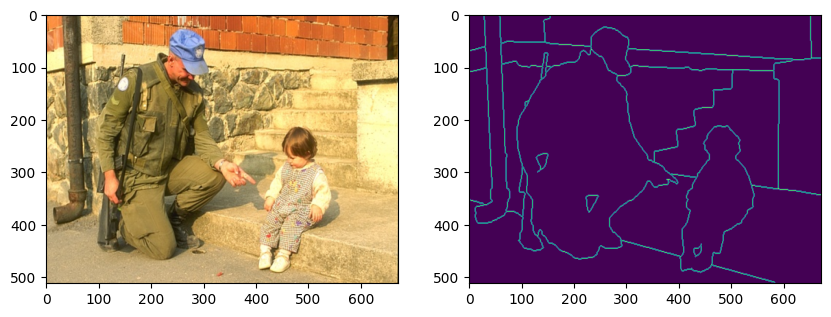

In [ ]:
plt.subplots(1,2,figsize=(10,10))

index = 56

plt.subplot(1, 2, 1)
plt.imshow(xtrain[index])

plt.subplot(1, 2, 2)
plt.imshow(ytrain[index])

In [ ]:
# drive.mount('/content/myDrive', force_remount=True)
# pickle_savepath = '/content/myDrive/MyDrive/edge_unet/save.pickle'
# pickle_out = open(pickle_savepath,'wb')
# pickle.dump((xtrain, xtest, xval, ytrain, ytest, yval),pickle_out )
# pickle_out.close()
# drive.flush_and_unmount()

## Check Data

In [ ]:
# drive.mount('/content/myDrive', force_remount=True)
# path = '/content/myDrive/MyDrive/edge_unet/save.pickle'
# pickle_in = open(path, 'rb')
# (xtrain, xtest, xval, ytrain, ytest, yval) = pickle.load(pickle_in)
# drive.flush_and_unmount()

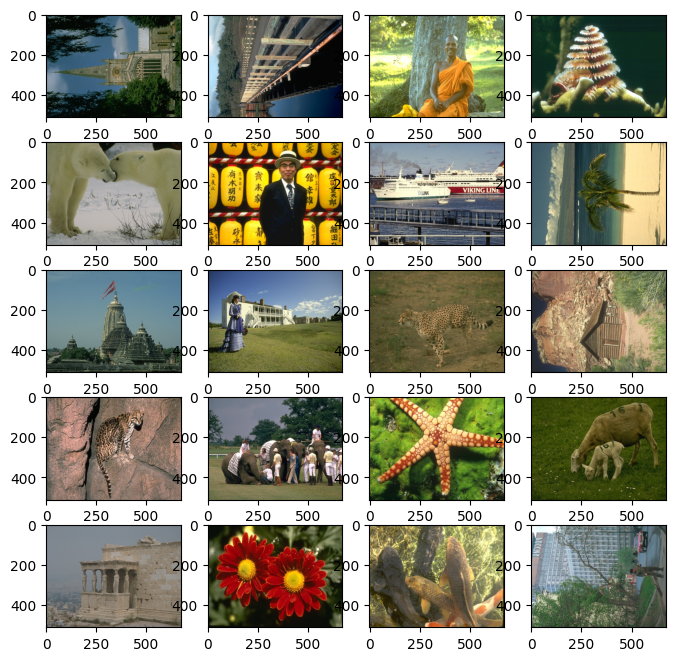

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

plot_images = random.choices(xtrain, k=21)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(plot_images[i])
plt.show()

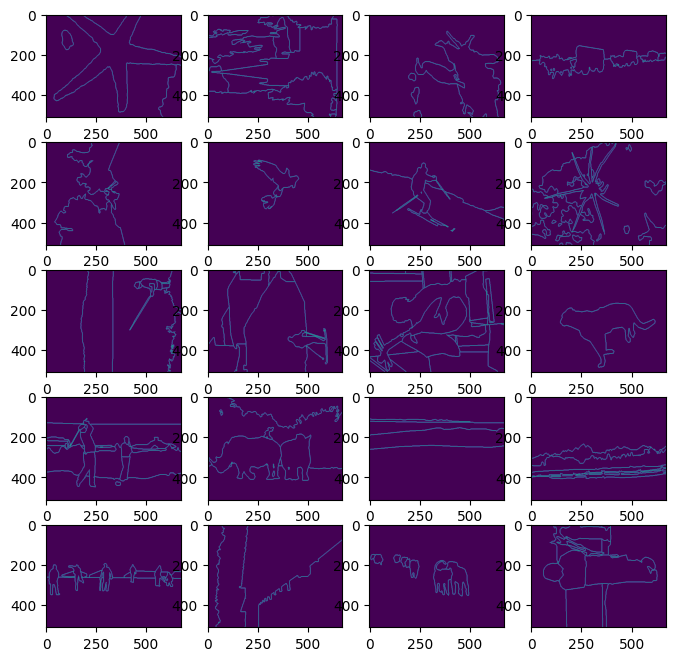

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

plot_images = random.choices(ytrain, k=21)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(plot_images[i])
plt.show()

In [ ]:
import os

augmented_image_dir = '/content/images'
augmented_label_dir = '/content/ground_truth'

os.makedirs(augmented_image_dir + 'train', exist_ok=True)
os.makedirs(augmented_image_dir + 'val', exist_ok=True)
os.makedirs(augmented_image_dir + 'test', exist_ok=True)

os.makedirs(augmented_label_dir + 'train', exist_ok=True)
os.makedirs(augmented_label_dir + 'val', exist_ok=True)
os.makedirs(augmented_label_dir + 'test', exist_ok=True)


In [ ]:
def augment_and_save_gpu(images, labels, image_save_dir, label_save_dir, num_augmentations=8):
    # Convert lists to tensors and move to GPU
    image, label = [],[]
    images_tensor = torch.stack([torch.from_numpy(img).permute(2, 0, 1) for img in images]).float().cuda()
    labels_tensor = torch.stack([torch.from_numpy(lbl) for lbl in labels]).unsqueeze(1).float().cuda()

    # Augmentation functions in Kornia
    augmentation_transforms = [
        kornia.augmentation.RandomHorizontalFlip(p=1.0),
        kornia.augmentation.RandomVerticalFlip(p=1.0),
        kornia.augmentation.RandomRotation(degrees=90.0),
        kornia.augmentation.RandomRotation(degrees=180.0),
        kornia.augmentation.RandomRotation(degrees=270.0),
        kornia.augmentation.RandomAffine(degrees=0.0, translate=(0.1, 0.1)),
        kornia.augmentation.RandomAffine(degrees=0.0, scale=(0.9, 1.1)),
        kornia.augmentation.RandomAffine(degrees=0.0, shear=(10.0, 10.0)),
    ]

    for i, transform in enumerate(augmentation_transforms):
        # Apply transform to images and labels
        augmented_imgs = transform(images_tensor)
        augmented_lbls = transform(labels_tensor)

        # Move back to CPU and convert to numpy arrays
        augmented_imgs_cpu = augmented_imgs.cpu()
        augmented_lbls_cpu = augmented_lbls.cpu()

        for idx in range(augmented_imgs_cpu.size(0)):
            # Convert tensors to images
            img_np = augmented_imgs_cpu[idx].permute(1, 2, 0).numpy().astype('uint8')
            lbl_np = augmented_lbls_cpu[idx, 0].numpy().astype('uint8')

            # Save images and labels
            Image.fromarray(img_np).save(os.path.join(image_save_dir, f'{idx}_aug_{i}.jpg'))
            Image.fromarray(lbl_np).save(os.path.join(label_save_dir, f'{idx}_aug_{i}.jpg'))

            image.append(img_np)
            label.append(lbl_np)

    return image, label

In [ ]:
# # Augment and save training data using GPU
# x_train, y_train = augment_and_save_gpu(
#                     xtrain,
#                     ytrain,
#                     augmented_image_dir + '/train',
#                     augmented_label_dir + '/train',
#                     num_augmentations=8
#                 )

# x_val,y_val = augment_and_save_gpu(
#               xval,
#               yval,
#               augmented_image_dir + '/val',
#               augmented_label_dir + '/val',
#               num_augmentations=8
#           )

# x_test, y_test = augment_and_save_gpu(
#                   xtest,
#                   ytest,
#                   augmented_image_dir + '/test',
#                   augmented_label_dir + '/test',
#                   num_augmentations=8
#               )


In [ ]:
# plt.imshow(ytrain[0,0,:,:])

In [ ]:
# del xtrain, xtest, xval, ytrain, yval, ytest

## Model


In [ ]:
class convd(nn.Module): #every levels convolution
    def __init__(self, input, output):
        super(convd,self).__init__()
        self.seqconv = nn.Sequential(
                nn.Conv2d(input,output,3,1,1,bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True),
                nn.Conv2d(output,output, 3,1,1, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.seqconv(x)

class UNET(nn.Module):

    def __init__(self, feature_out):
        super(UNET, self).__init__()
        self.down_descent = nn.ModuleList()
        self.up_climb = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        self.dropout = nn.Dropout(0.4)
        self.features=[64,128,256,512]
        self.input = 3

        for i in self.features:
            self.down_descent.append(convd(self.input,i))
            self.input = i

        for i in reversed(self.features):
            self.up_climb.append(
                nn.ConvTranspose2d(i*2, i ,2 ,stride = 2))
            self.up_climb.append(convd(i*2, i))

        self.bottom_layer = convd(self.features[-1], self.features[-1]*2)
        self.final_layer = nn.Conv2d(self.features[0],feature_out, kernel_size=1)

    def forward(self,x):
        skip_connections  =[]
        for down in self.down_descent:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)
            x = self.dropout(x)
        #Add bottom layer
        x = self.bottom_layer(x)
        #reverse skip connections
        skip_connections = skip_connections[::-1]

        #refer paper
        for i in range(0,len(self.up_climb),2):
            sc = skip_connections[i//2]
            x = self.up_climb[i](x)

            if x.shape !=sc.shape:
                x = TF.resize(x, size = sc.shape[2:])

            join_x = torch.cat((sc,x), dim=1)
            x = self.up_climb[i+1](join_x)

        x = self.final_layer(x)

        return x


# def test():
#     x = torch.randn(1,3,320,480)
#     model = UNET(feature_out = 3)
#     preds = model(x)
#     print(preds.shape)
#     print(x.shape)
#     assert preds.shape == x.shape

# if __name__ == "__main__":
#     test()


In [ ]:
model = UNET(1)
model = model.to(device)
print(device)
summary(model, input_size=(3, 512, 672))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 672]           1,728
       BatchNorm2d-2         [-1, 64, 512, 672]             128
              ReLU-3         [-1, 64, 512, 672]               0
            Conv2d-4         [-1, 64, 512, 672]          36,864
       BatchNorm2d-5         [-1, 64, 512, 672]             128
              ReLU-6         [-1, 64, 512, 672]               0
             convd-7         [-1, 64, 512, 672]               0
         MaxPool2d-8         [-1, 64, 256, 336]               0
           Dropout-9         [-1, 64, 256, 336]               0
           Conv2d-10        [-1, 128, 256, 336]          73,728
      BatchNorm2d-11        [-1, 128, 256, 336]             256
             ReLU-12        [-1, 128, 256, 336]               0
           Conv2d-13        [-1, 128, 256, 336]         147,456
      BatchNorm2d-14        [-1, 1

## Load Dataloader

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((512, 672)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((512, 672)),
    transforms.ToTensor()
])

In [ ]:
# image_transform = A.Compose([
#     A.Resize(320, 480),
#     A.Normalize(mean=(0.485, 0.456, 0.406),
#                 std=(0.229, 0.224, 0.225)),
#     ToTensorV2(),
# ])

# label_transform = A.Compose([
#     A.Resize(320, 480),
#     ToTensorV2(),
# ])

In [ ]:
class bsds_Dataloader(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.mat')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        # Load label
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        label = scipy.io.loadmat(label_path)['groundTruth'][0][0][0][0][1]
        label = Image.fromarray((label * 255).astype(np.uint8))  # Convert to uint8

        # transforms
        if self.image_transform :
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label


In [ ]:
image_dir ='/content/images'
labels_dir = '/content/ground_truth'

training = bsds_Dataloader(image_dir = image_dir+'/train',
                           label_dir = labels_dir+'/train',
                           image_transform=image_transform,
                           label_transform=label_transform)

validation = bsds_Dataloader(image_dir = image_dir+'/val',
                             label_dir = labels_dir+'/val',
                             image_transform=image_transform,
                             label_transform=label_transform)

test = bsds_Dataloader(image_dir = image_dir+'/test',
                       label_dir = labels_dir+'/test',
                       image_transform=image_transform,
                       label_transform=label_transform)


In [ ]:
train_dataloader = DataLoader(training, batch_size=4, shuffle=True)
val_dataloader = DataLoader(validation, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test, batch_size=1, shuffle=False)

val
torch.Size([4, 3, 512, 672])
torch.Size([4, 1, 512, 672])


train
torch.Size([4, 3, 512, 672])
torch.Size([4, 1, 512, 672])


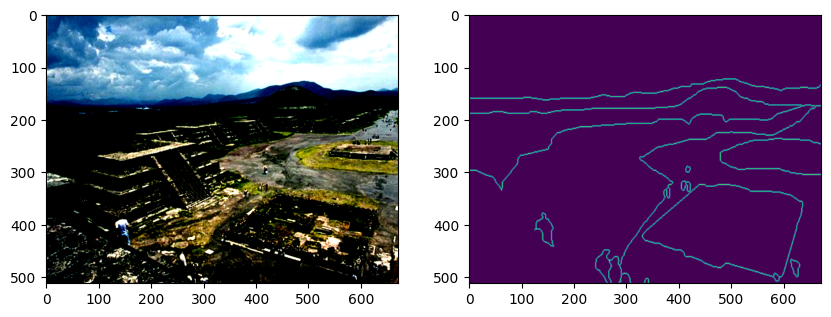

In [ ]:
images, labels = next(iter(val_dataloader))
print('val')
print(images.shape)
print(labels.shape)

images, labels = next(iter(train_dataloader))
print('train')
print(images.shape)
print(labels.shape)


plt.subplots(1,2,figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(labels[0].permute(1, 2, 0))


In [ ]:
def calculate_edge_weight(dataloader,penaliser):
    total_pixels = 0
    total_edge_pixels = 0

    for images, labels in dataloader:
        batch_size, _, height, width = labels.size()
        total_pixels += batch_size * height * width
        total_edge_pixels += labels.sum().item()

    total_non_edge_pixels = total_pixels - total_edge_pixels
    edge_weight = total_non_edge_pixels / total_edge_pixels
    return edge_weight, edge_weight / penaliser

## Training & Validation

In [ ]:
lr = 0.02
epochs = 16
num_class = 1

edge_weight, ew_p = calculate_edge_weight(dataloader=train_dataloader,penaliser = 1.2)
edge_weight_tensor = torch.tensor([ew_p]).to(device)
print(f"Calculated edge_weight: {edge_weight}")
print(f"Calculated penalised edge_weight: {ew_p}")

model = UNET(num_class).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = edge_weight_tensor) #pos_weight = edge_weight_tensor
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

Calculated edge_weight: 60.00805210742338
Calculated penalised edge_weight: 50.00671008951949


In [ ]:


def calc_loss(prediction, targets, metrics):
    loss = criterion(prediction, targets)
    metrics['loss'] +=  loss.data.cpu().numpy() * targets.size(0)

    return loss


In [ ]:
# Model, Loss, Optimizer
def model_val_train(train, val, epochs, optimizer, scheduler, model=model):

    train_losses = []
    val_losses = []

    model_saver = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    num_epochs = epochs
    epoch_loss = 0

    for epoch in range(num_epochs):
        print()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for state in ['train','valid']:

            if state == 'train':
                scheduler.step(epoch_loss)
                print("Current learning rate:",optimizer.param_groups[0]['lr'])
                print()
                model.train()
                dataloader = train
            else:
                model.eval()
                dataloader = val

            metrics = defaultdict(float)
            epoch_size = 0
            progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"{state} Epoch {epoch + 1}")

            for idx,(images,edges) in progress_bar:

                images = images.to(device)
                edges = edges.float().to(device)

                if state == 'train':
                    optimizer.zero_grad() 

                with torch.set_grad_enabled(state == 'train'):
                    outputs = model(images)
                    loss = calc_loss(outputs, edges, metrics) 

                    if state == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_size += images.size(0)

                progress_bar.set_postfix({
                    'Loss': loss.item(),
                })

            epoch_loss = metrics['loss'] /epoch_size

            if state == 'valid':
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

            if state == 'valid' and epoch_loss < best_loss:
                print('Found a better model')
                best_loss = epoch_loss
                model_saver = copy.deepcopy(model.state_dict())

    model.load_state_dict(model_saver)
    check_point={
        'epoch':epoch,
        'loss':best_loss,
        'model': model.state_dict(),
        'optimizer':optimizer.state_dict()
        }
    return model, train_losses, val_losses, best_loss, check_point


def save_best_model(checkpoint):
    drive.mount('/content/myDrive', force_remount=True)
    location = '/content/myDrive/MyDrive/edge_unet/unet_model.pth.tar'
    torch.save(checkpoint, location)
    drive.flush_and_unmount()


In [ ]:
model, train_losses, val_losses, best_loss, check_point = model_val_train(train_dataloader, val_dataloader, epochs, optimizer, scheduler, model)
print('Downloading the best Model')
save_best_model(check_point)


Epoch 1/16
----------
Current learning rate: 0.02



valid Epoch 1: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s, Loss=1.27]


Found a better model

Epoch 2/16
----------
Current learning rate: 0.02



valid Epoch 2: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s, Loss=1.27]



Epoch 3/16
----------
Current learning rate: 0.02



valid Epoch 3: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.2]


Found a better model

Epoch 4/16
----------
Current learning rate: 0.004



valid Epoch 4: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.15]


Found a better model

Epoch 5/16
----------
Current learning rate: 0.004



valid Epoch 5: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s, Loss=1.09]


Found a better model

Epoch 6/16
----------
Current learning rate: 0.004



valid Epoch 6: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.1]


Found a better model

Epoch 7/16
----------
Current learning rate: 0.0008



valid Epoch 7: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s, Loss=1.08]


Found a better model

Epoch 8/16
----------
Current learning rate: 0.0008



valid Epoch 8: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.06]


Found a better model

Epoch 9/16
----------
Current learning rate: 0.0008



valid Epoch 9: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.05]


Found a better model

Epoch 10/16
----------
Current learning rate: 0.00016



valid Epoch 10: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s, Loss=1.03]


Found a better model

Epoch 11/16
----------
Current learning rate: 0.00016



valid Epoch 11: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.02]



Epoch 12/16
----------
Current learning rate: 0.00016



valid Epoch 12: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s, Loss=1.04]


Found a better model

Epoch 13/16
----------
Current learning rate: 3.2000000000000005e-05



valid Epoch 13: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s, Loss=1.03]


Found a better model

Epoch 14/16
----------
Current learning rate: 3.2000000000000005e-05



valid Epoch 14: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.03]



Epoch 15/16
----------
Current learning rate: 3.2000000000000005e-05



valid Epoch 15: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s, Loss=1.03]


Found a better model

Epoch 16/16
----------
Current learning rate: 6.400000000000001e-06



valid Epoch 16: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s, Loss=1.04]


Found a better model
Mounted at /content/myDrive


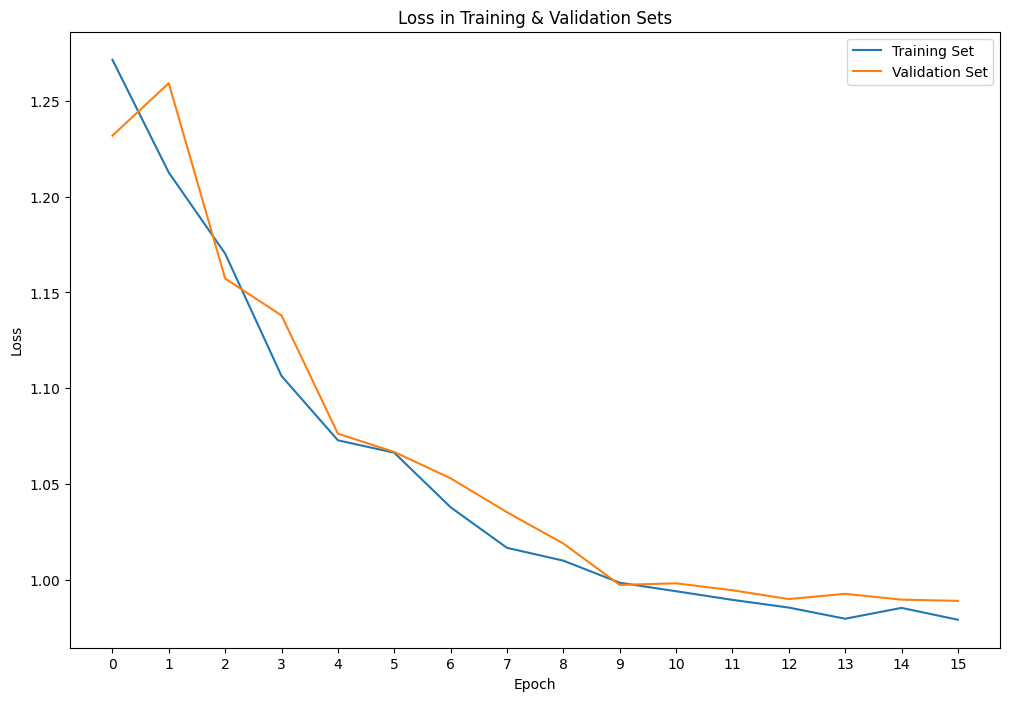

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(len(train_losses)), train_losses, label = 'Training Set')
plt.plot(range(len(val_losses)), val_losses, label = 'Validation Set')
plt.xticks(range(len(val_losses)))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Training & Validation Sets')
plt.show()

## Testing

In [ ]:
i = 0

model.eval()

inputs, labels = next(iter(test_dataloader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
pred = pred[i, 0, :, :]
pred_prob = pred.copy()
pred = np.where(pred>=0.5, 1, 0)

gt = np.asarray(ytest)[i, :, :]

org = np.asarray(xtest)[i, :, :, :]

In [ ]:
# accuracy
accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

# precision
tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
precision = tp / (tp + fp)

# recall
fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
recall = tp / (tp + fn)

# f-value
fvalue = 2 * precision * recall / (precision + recall)

# mean Average Precision


In [ ]:
print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}')

Accuracy: 0.88, Precision: 0.0004, Recall: 0.0144, F-value: 0.0007


Text(0.5, 1.0, 'Pred')

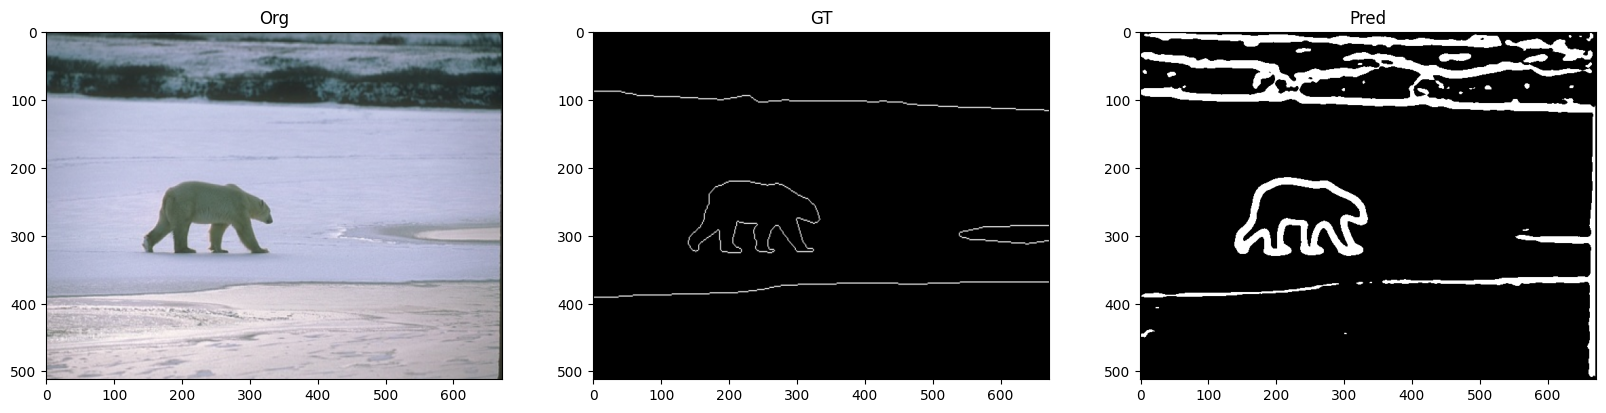

In [ ]:
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org)
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt, cmap='gray')
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title('Pred')

In [ ]:
num_it = len(test_dataloader)

model.eval()   # Set model to evaluate mode

test_loader = test_dataloader
iterator = iter(test_loader)

org_list = []
gt_list = []
pred_list = []
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(num_it):
    inputs, labels = next(iterator)
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    pred = pred[0, 0, :, :]

    # arrays
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    gt = ytest[i, 0, :, :]
    org = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(int)

    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)

    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))

    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    org_list.append(org)
    gt_list.append(gt)
    pred_list.append(pred)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)